### Importing dependencies

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Dataset Dependencies
from tensorflow.keras.datasets import mnist
from sklearn.utils import shuffle

import time
import os



### Loading Trainset and Testset

In [55]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the pixel values to the range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Neural network structure

### Auxiliar functions

Activation functions and its derivatives

In [56]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def deriv_sigmoid(z):
    return z*(1-z)



def leakyrelu(z, alpha=0.0):
    return np.maximum(alpha*z, z)

def deriv_leakyrelu(z, alpha=0.0):
   # Create a mask for elements greater than 0
    greater_than_zero = z > 0
    # Create a mask for elements less than or equal to 0
    less_than_zero = ~greater_than_zero
    # Apply derivative conditions for elements greater than 0 and less than or equal to 0
    deriv = np.ones_like(z, dtype = float)
    deriv[less_than_zero] = alpha
    return deriv



def softmax(z):
    e_x = np.exp(z - np.max(z))
    return e_x / e_x.sum()

def deriv_softmax(z):
    # Compute softmax function
    softmax_z = np.exp(z) / np.sum(np.exp(z), axis=0)
    # Compute Jacobian matrix for softmax
    softmax_grad = np.diag(softmax_z) - np.outer(softmax_z, softmax_z)
    return softmax_grad

Loss function

In [57]:
def loss_func(label, pred):
    return 0.5*(label - pred)**2

Function to save a report of the training parameters and results

In [116]:
def save_report(flag, model,epochs, batch_size, lr, activation_func, optimizer, training_report, acc):
    if flag == True:
        folder_path = './training_reports' 

        file_names = os.listdir(folder_path) # Get a list of all files in the folder
        idxs = [int(file[-5]) for file in file_names]
        current_idx = max(idxs)+1

        with open(f'training_reports/training_report_{current_idx}.txt', 'w') as file:
            current_datetime = datetime.datetime.now()
            strings_to_write = [
                f"Training Date and Time: {current_datetime}",
                f" ",
                f"Net structure: {model.params}",
                f" ",
                f"Epoch number: {epochs}",
                f"Batch size: {batch_size}",
                f"Learning rate: {lr}",
                f" ",
                f"Activation function: {activation_func}",
                f"Optimizer: {optimizer}",
                f" ",
                f"Accuracy: {acc:.2f}%",
                f" ",
                f"Epoch Info: ",
            ]

            # Adding a newline after each string
            [file.write(string + '\n') for string in strings_to_write] 
            [file.write(i + '\n') for i in training_report]
        print(f"The repor for the current training has been saved under: training_report_{current_idx}.txt") 

### Neural network class

In [80]:
class NN():
    def __init__(self, params):
        self.params = params # format: [input_size, a1_size, a1_size, ...  output_size]

        # For all the lists, each element is a matrix of values for 1 layer

        # This list holds the activtions for just 1 pass (the forward calculates and resets it everytime it executes)
        self.activations_list = []  # [input_vector , a1_vector, a2_vector, ... output_vector]
        self.z_list = []  # s list to calculate the derivative of the relu and leaky rely
        # This lists holds the weiths and biases until they are updated by the optimization() method
        self.weight_list = [np.random.normal(size=[params[i], params[i+1]], loc = 0.0, scale = 1.0) for i in range(len(params)-1)]
        self.bias_list = [np.random.normal(size=[params[i+1],], loc = 0.0, scale = 1.0) for i in range(len(params)-1)]
        # This list hold the cumulated gradients of the weights and biases for all layers for 1 batch
        self.dLdw_list_acumulated = [0]*(len(params)-1)
        self.dLdb_list_acumulated = [0]*(len(params)-1)
        # This lists hold the cumulated momentums factor (for Adam opttimizer) for all layers for 1 batch 
        self.m_b = [0]*(len(params)-1)
        self.m_w = [0]*(len(params)-1)
        # This lists hold the cumulated RMSProp factors (for adam optimizer) for all layers  for 1 batch
        self.r_w = [0]*(len(params)-1)
        self.r_b = [0]*(len(params)-1)

        print(" ----- Neural net layout -----")
        print(f"    Input with {params[0]} valeus")
        for i in range(len(params)-2):
            print(f"    Hidden layer {i+1} with {params[i+1]} nodes")
        print(f"    Output with {params[-1]} nodes")
        print(" -----------------------------")

    def reset_cumulated_gradients(self):
        self.dLdw_list_acumulated =  [0]*(len(self.params)-1) # initial value
        self.dLdb_list_acumulated =  [0]*(len(self.params)-1) # initial value

    def reset_cumulated_adam_factors(self):
        self.m_b = [0]*(len(self.params)-1) 
        self.r_w = [0]*(len(self.params)-1) 
        self.r_b = [0]*(len(self.params)-1) 
        self.m_w = [0]*(len(self.params)-1) 

    def forward(self, input, activation_func):
        # This function runs for every sample and the loop iterates over every layer to cover the whlole network
        self.z_list = [0]
        self.activations_list = [input] # Creates a list for the activation with the input vector as it is the a0 layers
        for i in range(len(self.params)-1): # Adds the other layers (n-1)layers because the input has been added already
            zi = np.dot(np.transpose(self.weight_list[i]), self.activations_list[i]) + self.bias_list[i]
            if i == (len(self.params)-2): # if last layer
                ai = softmax(zi)
            else:
                if activation_func == "leakyrelu":
                    ai = leakyrelu(zi)
                if activation_func == "sigmoid":
                    ai = sigmoid(zi)

            self.z_list.append(zi)
            self.activations_list.append(ai)
        return ai

    def backpropagation(self, label, batch_size, activation_func, optimizer):
        # This function runs for every sample and the loop iterates over every layer to cover the whlole network

        # Each elemnt of this list is a matrix of weight for one layer OBS: the values are gonna be added from the last to the first item
        # The list represents the weights of all layers for the current sample (1 sample)
        dLdw_list = []
        dLdb_list = []

        for i in range(len(self.params)-1): # iters over all hidden layers and the output    ->   len(params)-1 
            if i == 0: # If the first calculation (output layer)
                output = self.activations_list[::-1][i]
                dLdout = (output - label)

                if activation_func == "leakyrelu": # if using leaky relu, the activation of the output layer has to be a softmax
                    dadz = deriv_softmax(self.z_list[::-1][i]) # derivative of the softmax
                    cumulative_partials = np.dot(dadz, dLdout) # cumulative for softmax (dot product)
                if activation_func == "sigmoid":
                    dadz = deriv_sigmoid(self.activations_list[::-1][i]) # derivative of the sigmoid
                    cumulative_partials = dadz* dLdout # cumulative for sigmoid

            else: # For the derivatives of all other layers (exept the last one)
                dzda = self.weight_list[::-1][i-1]

                if activation_func == "leakyrelu":
                    dadz = deriv_leakyrelu(self.z_list[::-1][i]) 
                if activation_func == "sigmoid": 
                    dadz = deriv_sigmoid(self.activations_list[::-1][i])
                cumulative_partials = dadz*np.dot(dzda, cumulative_partials)

            dzdw = self.activations_list[::-1][i+1] # element l-1 in the NN standard notation, but because the list in inverted, its index is i+1
            dzdb = 1

            transp_cumulative_partials = np.transpose(cumulative_partials.reshape(-1,1))

            gradient_w = np.dot(dzdw.reshape(-1,1), transp_cumulative_partials)
            gradient_b = dzdb*cumulative_partials
            
            # Append the gradient matrix for one layer
            dLdw_list.append(gradient_w)
            dLdb_list.append(gradient_b)

            # ----- Requirements for the any optimizer -------
            self.dLdw_list_acumulated[i] += gradient_w/batch_size
            self.dLdb_list_acumulated[i] += gradient_b/batch_size

            # ----- Requirements for the Adam optimizer ------- 
            beta_1 = 0.9
            beta_2 = 0.999
            if optimizer == "momentum" or optimizer == "Adam":
                self.m_w[i] = (beta_1*self.m_w[i] + (1 - beta_1)*dLdw_list[i])  
                self.m_b[i] = (beta_1*self.m_b[i] + (1 - beta_1)*dLdb_list[i])   

            if optimizer == "Adam":
                self.r_w[i] = (beta_2*self.r_w[i] + (1 - beta_2)*dLdw_list[i]**2)
                self.r_b[i] = (beta_2*self.r_b[i] + (1 - beta_2)*dLdb_list[i]**2)
            

    def optimization(self, alpha, optimizer, sample_index):
        # This function runs every batch to update the weights and biases with the cumulated derivatives
        e = 10e-8
        beta_1 = 0.9
        beta_2 = 0.999

        if optimizer == "SGD":
            self.weight_list = [(self.weight_list[i] - alpha*self.dLdw_list_acumulated[::-1][i]) for i in range(len(self.weight_list))] 
            self.bias_list =   [(self.bias_list[i]   - alpha*self.dLdb_list_acumulated[::-1][i]) for i in range(len(self.bias_list))]  

        if optimizer == "momentum":
            for i in range(len(self.weight_list)):
                self.weight_list[i] -= alpha*self.m_w[::-1][i] 
                self.bias_list[i] -= alpha*self.m_b[::-1][i]   
        
        if optimizer == "Adam":
            for i in range(len(self.weight_list)):
                m_w_corrected = self.m_w[::-1][i] / (1-beta_1**(sample_index))
                r_w_corrected = self.r_w[::-1][i] / (1-beta_2**(sample_index))
                m_b_corrected = self.m_b[::-1][i] / (1-beta_1**(sample_index))
                r_b_corrected = self.r_b[::-1][i] / (1-beta_2**(sample_index))

                self.weight_list[i] -= alpha* m_w_corrected / (e + np.sqrt(r_w_corrected))
                self.bias_list[i] -= alpha*  m_b_corrected / (e + np.sqrt(r_b_corrected))

 
        
        
    


# Training process

Model and parameters definition

In [81]:
model = NN([784, 16, 10])

batch_size = 20
epochs = 6
lr = 0.01
activation_func = "sigmoid"
optimizer = "Adam"
graph_samples = 80

save_report_lag = True

 ----- Neural net layout -----
    Input with 784 valeus
    Hidden layer 1 with 16 nodes
    Output with 10 nodes
 -----------------------------


Training loop

Epoch 1/6,   epoch loss: 0.018606,   epoch time: 34.7s
Epoch 2/6,   epoch loss: 0.0090627,   epoch time: 36.4s
Epoch 3/6,   epoch loss: 0.0074526,   epoch time: 35.3s
Epoch 4/6,   epoch loss: 0.0066097,   epoch time: 36.9s
Epoch 5/6,   epoch loss: 0.0060799,   epoch time: 35.7s
Epoch 6/6,   epoch loss: 0.0057091,   epoch time: 37.8s


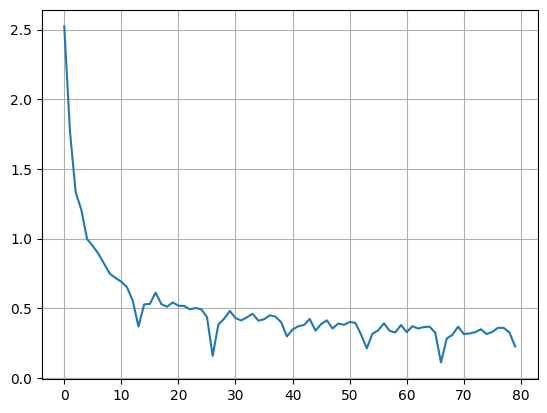

In [82]:

sample_idx = 1
loss_list = []
training_report = []
loss_append_flag = epochs*len(x_train)//graph_samples
for i in range(epochs):
    loss = 0
    loss_cumulated = 0
    loss_cumulated_epoch = 0
    # shuffle the training data for each epochs
    x_train_shuffled, y_train_shuffled = shuffle(x_train, y_train)
    epoch_time = time.time()
    for j in np.arange(batch_size, len(y_train)+1, batch_size):
        batch = zip(x_train[j-batch_size : j], y_train[j-batch_size : j])

        for x, y in batch:
            a0 = x.ravel()
            output = model.forward(a0, activation_func)

            target = np.zeros(10)
            target[y] = 1

            sample_idx +=1
            model.backpropagation(target, batch_size, activation_func, optimizer)

            loss_raw = 0.5*(target - output)**2
            loss = sum(loss_raw)/len(loss_raw)
            loss_cumulated_epoch += loss
            loss_cumulated += loss
            
            if sample_idx % loss_append_flag == 0:
                loss_list.append(loss_cumulated/graph_samples)
                loss_cumulated = 0
        

        model.optimization(lr, optimizer, sample_idx)
        model.reset_cumulated_gradients()

        
    epoch_loss = loss_cumulated_epoch/len(y_train)
    epoch_timespam = time.time() - epoch_time
    epoch_data = f"Epoch {(i+1)}/{epochs},   epoch loss: {epoch_loss:.5f},   epoch time: {epoch_timespam:.1f}s"
    print(epoch_data)
    training_report.append(epoch_data)
model.reset_cumulated_adam_factors()


# ------------- Plot the loss graph ----------------
y_axis = loss_list
x_axis = [i for i in range(len(y_axis))]
plt.plot(x_axis, y_axis, )
plt.grid()
plt.show()

# ---------------- Getting accuracy ----------------
f = 0
v = 0
for i in range(x_test.shape[0]):
    x = x_test[i].ravel()
    y = y_test[i]
    output = model.forward(x, activation_func)
    # bla.reset()
    predicted = np.argmax(output)
    if predicted == y:
        v +=1
    else:
        f+=1
acc = v / (v+f) * 100
print(f"The model correctly predicted {v} out of {v+f} test cases, achieving an accuracy of {acc:.2f}%.")

# ------------ Save the training report ------------
save_report(save_report_lag, model,epochs, batch_size, lr, activation_func, optimizer, training_report, acc)



# Evaluation process

In [60]:
model = NN([784, 16, 10])

 ----- Neural net layout -----
    Input with 784 valeus
    Hidden layer 1 with 16 nodes
    Output with 10 nodes
 -----------------------------


In [65]:
load_params = False

if load_params == True:
    loaded_weights = np.load('saved_weights.npy', allow_pickle=True)
    loaded_biases = np.load('saved_biases.npy', allow_pickle=True)

    model.weight_list = loaded_weights
    model.bias_list = loaded_biases



In [62]:
f = 0
v = 0
for i in range(x_test.shape[0]):
    x = x_test[i].ravel()
    y = y_test[i]
    output = model.forward(x, activation_func)
    # bla.reset()
    predicted = np.argmax(output)
    if predicted == y:
        v +=1
    else:
        f+=1
print(f"The model correctly predicted {v} out of {v+f} test cases, achieving an accuracy of {v / (v+f) * 100:.2f}%.")

The model correctly predicted 9034 out of 10000 test cases, achieving an accuracy of 90.34%.


In [45]:
save_params = False

if save_params == True:
    np.save('saved_weights.npy', model.weight_list)
    np.save('saved_biases.npy', model.bias_list)

/home/marco/miniconda3/envs/FaceID_2-env/lib/python3.10/site-packages/numpy/lib/npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


# Visualization

### Loss visualization

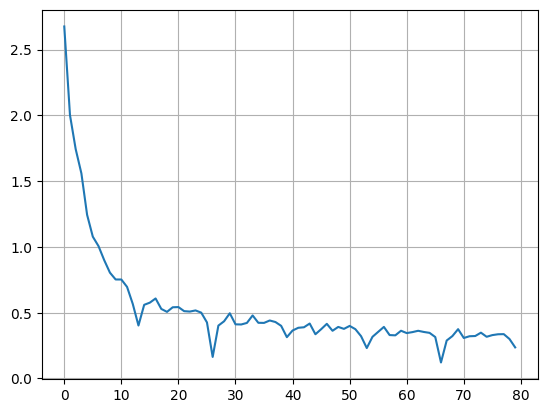

In [33]:
y_axis = loss_list
x_axis = [i for i in range(len(y_axis))]
plt.plot(x_axis, y_axis, )
plt.grid()
plt.show()

### Weights distribution

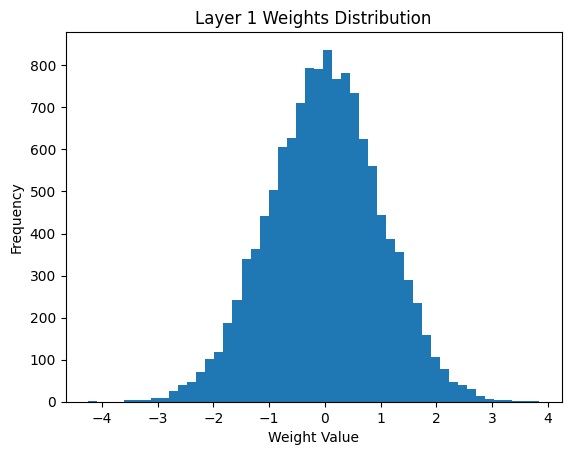

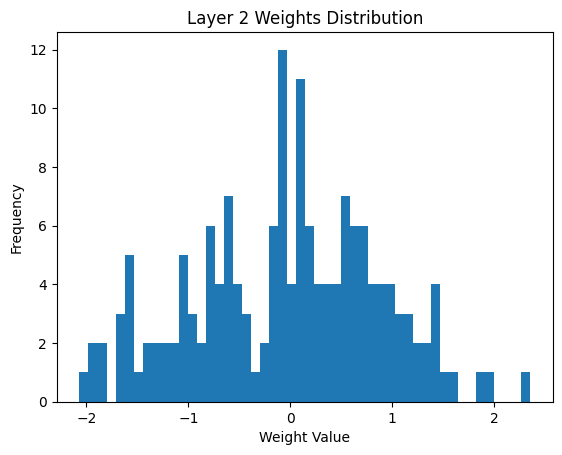

In [53]:
for i, layer_weights in enumerate(model.weight_list):
    plt.figure()
    plt.hist(layer_weights.flatten(), bins=50)
    plt.title(f'Layer {i+1} Weights Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.show()